In [1]:
%%configure -f
{"name": "arik", "executorMemory": "8G", "numExecutors": 4, "executorCores": 2,
 "conf": {"spark.yarn.appMasterEnv.PYSPARK_PYTHON":"python3"}}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
128,application_1580142637008_0137,pyspark,idle,Link,Link,
131,application_1580142637008_0140,pyspark,idle,Link,Link,
136,application_1580142637008_0145,pyspark,idle,Link,Link,


In [2]:
import sys
import subprocess
from io import BytesIO
from gzip import GzipFile
from pyspark.sql import Row

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
138,application_1580142637008_0147,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
def get_fits_module():
    if 'astropy' not in sys.modules:
        stdout = subprocess.check_output(
            sys.executable + ' -m pip install astropy',
            stderr=subprocess.STDOUT,
            shell=True).decode('utf-8')
    from astropy.io import fits
    return fits

def getfits(compressed_data):
    fits = get_fits_module()
    decomp = GzipFile(fileobj=BytesIO(compressed_data)).read()
    fits_obj = fits.open(BytesIO(decomp))
    return fits_obj

# Spark dataframe cannot do numpy types
def typeconv(i):
    try:
        return i.item()
    except:
        return i

def headerDict(fits):
    return dict(fits[0].header.items())

def createFiberExposureRows(fits):
    obsinfo = fits['OBSINFO']
    obsinfo_columns = [i.name for i in obsinfo.columns]
    n_exposures = len(obsinfo.data)
    n_fibers = int(len(fits['FLUX'].data)/n_exposures)
    rows = []
    for exp in range(n_exposures):
        expinfo = dict(zip(obsinfo_columns, [typeconv(i) for i in obsinfo.data[exp]]))
        for fiber in range(n_fibers):
            ind = exp*n_fibers + fiber
            row = headerDict(fits)
            row.update(expinfo)
            row['EXPOSURE_INDEX'] = exp
            row['FIBER_INDEX'] = fiber
            # Per fiber/exposure data
            for unit in ['FLUX', 'XPOS', 'YPOS', 'IVAR', 'MASK', 'DISP']:
                row[unit] = fits[unit].data[ind].tolist()
            # references all spectra
            for unit in ['WAVE', 'SPECRES', 'SPECRESD']:
                row[unit] = fits[unit].data.tolist()
            # for convenience, store the mean fiber positions
            row['XPOS_MEAN'] = fits['XPOS'].data[ind].mean().tolist()
            row['YPOS_MEAN'] = fits['YPOS'].data[ind].mean().tolist()
            rows.append(Row(**row))
    return rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
manga_fits = sc.binaryFiles('hdfs:///manga/fits/').mapValues(getfits)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
tabledata = manga_fits.flatMap(lambda x: createFiberExposureRows(x[1]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df = spark.createDataFrame(tabledata)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df.write.parquet('hdfs:///manga/arik-test/flux')

In [ ]:
spark.sql('SET spark.sql.parquet.compression.codec = gzip')
df.write.parquet('hdfs:///manga/arik-test/flux-gz')

In [7]:
df.cache().createOrReplaceTempView('flux')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%sql
SELECT SPEC.WAVE as wl, avg(SPEC.FLUX) AS ifu_avg_flux FROM (
    SELECT explode_outer(arrays_zip(WAVE, FLUX)) AS SPEC
    FROM flux 
    WHERE MANGAID='1-115062' AND EXPOSURE_INDEX=0
) 
GROUP BY SPEC.WAVE
ORDER BY SPEC.WAVE ASC

In [19]:
from matplotlib import pyplot as plt
query = '''
SELECT XPOS_MEAN/3600.0+IFURA AS RA, YPOS_MEAN/3600.0+IFUDEC AS DEC, array_max(FLUX) as FLUXMN
FROM flux ORDER BY FLUXMN ASC
'''
res = spark.sql(query).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(332.95205, 333.15205000000003)

In [58]:
fig, ax = plt.subplots(1,1)
plt.scatter(res['RA'], res['DEC'], c=res['FLUXMN'], alpha=0.05, marker='H', cmap='hsv', s=20)
axins = ax.inset_axes([0.15, 0.1, 0.3, 0.3])
axins.scatter(res['RA'], res['DEC'], c=res['FLUXMN'], alpha=0.05, marker='H', cmap='hsv', s=20)
axins.set_xlim((333.05205-0.005, 333.05205+0.005))
axins.set_ylim((12.205191-0.005, 12.205191+0.005))
ax.indicate_inset_zoom(axins)
axins2 = ax.inset_axes([0.13, 0.65, 0.3, 0.3])
axins2.scatter(res['RA'], res['DEC'], c=res['FLUXMN'], alpha=0.05, marker='H', cmap='hsv', s=20)
axins2.set_xlim((332.20345-0.005, 332.20345+0.005))
axins2.set_ylim((13.364737-0.0001, 13.364737-0.0001))
ax.indicate_inset_zoom(axins2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(<matplotlib.patches.Rectangle object at 0x7f58abf0dfd0>, [<matplotlib.patches.ConnectionPatch object at 0x7f58abe93390>, <matplotlib.patches.ConnectionPatch object at 0x7f58abe935f8>, <matplotlib.patches.ConnectionPatch object at 0x7f58abe938d0>, <matplotlib.patches.ConnectionPatch object at 0x7f58abe93ba8>])
<string>:11: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=13.364637, top=13.364637

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

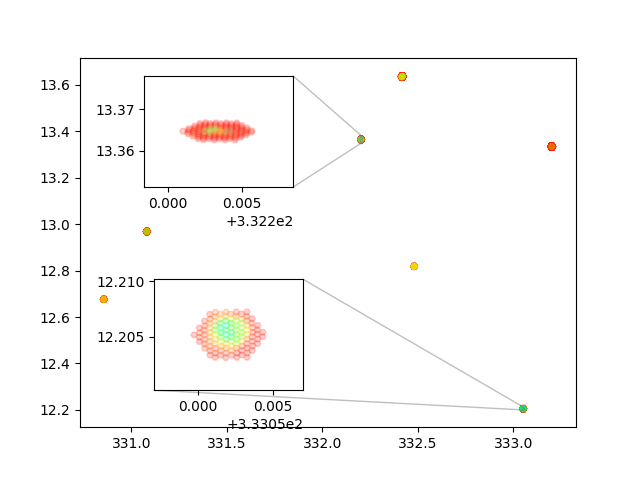

In [59]:
%matplot plt

In [11]:
%%sql
SELECT max(MANGAID), PLATEID, IFUDESIGN, avg(IFURA), avg(IFUDEC), avg(XPOS_MEAN), avg(YPOS_MEAN) FROM flux GROUP BY PLATEID, IFUDESIGN

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()